# Packages

In [4]:
# import packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import importlib

import winsound
import scipy.stats as stt
import networkx as nx

import pickle

import random

import sklearn
from sklearn.decomposition import FactorAnalysis
from factor_analyzer import FactorAnalyzer
import seaborn as sns

### Load, save or do nothing?

In [5]:
# Change this depending if you want to generate new data or load the previously generated ones
SAVE_OR_LOAD = "Load" # "Save, Load", "None"

### Functions

In [12]:
# from the selected items, it extracts the factors and the average

def get_factors_and_average(items_selected):
    
    dic_data = {i:list(el) for i,el in enumerate(items_selected)}
    df = pd.DataFrame(dic_data)

    fa = FactorAnalyzer(n_factors=4, rotation="varimax")
    fa.fit(df)
    df_matrix = pd.DataFrame(np.array(fa.loadings_)*1)
    fa_1_loadings = [el[1] for el in fa.loadings_]
    fa_1_loadings

    factor = items_selected[0]*0
    average = items_selected[0]*0

    for i, item in enumerate(items_selected):
        average = average + item
        factor = factor + item * fa_1_loadings[i]
        
    return factor, average

# Generate the different dimensions

In [6]:
N_pep = 10**3 # Number of people (i.e. respondents)
N_possible_quest = 5*10**4 # Number of items
levels = 5 # Number of possible responses for each items

change = 0.0018 # rate of change between contiguous items

# Generate all the possible questions and answers
possible_answers = []
ans_last = np.random.rand(N_pep)
for q in range(0, N_possible_quest):
    ans_t = np.random.rand(N_pep)
    ans = ans_last + 2*(change)*(ans_t-0.5)
    ans[ans<0] = 0
    ans[ans>1] = 1
    possible_answers.append(ans)
    
    ans_last = ans
    
# Round them    
for q in range(0, N_possible_quest):
    possible_answers[q] = np.ceil(possible_answers[q]*levels)

In [7]:
# Calculate the average correlation

avg_corr = []
for i in range (0,1000):
    v1 = random.choice(possible_answers)
    v2 = random.choice(possible_answers)
    avg_corr.append(stt.spearmanr(v1,v2)[0])
    
np.mean(avg_corr)

0.8782403073697232

# Make FA on N random items

In [8]:
# Make the dataframe on which we want to analyze the number of dimensions

items_to_select = 20

if SAVE_OR_LOAD=="Load":
    df = pd.read_csv("dataframe.csv")
else:
    items_selected = random.choices(possible_answers, k=items_to_select)

    dic_data = {i:list(el) for i,el in enumerate(items_selected)}
    df = pd.DataFrame(dic_data)
    
    if SAVE_OR_LOAD=="Save":
        df.to_csv("dataframe.csv")

In [9]:
# Run factor analysis

fa = FactorAnalyzer(n_factors=4, rotation="varimax")

fa.fit(df)

df_matrix = pd.DataFrame(np.array(fa.loadings_)*1)

Num eigenvecors =  2


Text(0, 0.5, 'Eigenvalue')

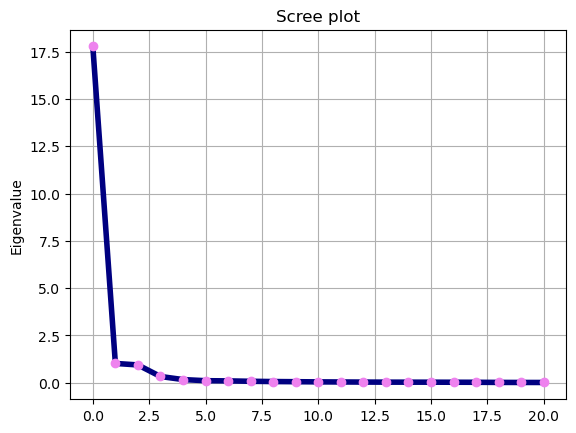

In [10]:
# Make the Scree plot

plt.plot(fa.get_eigenvalues()[0], linewidth=4, color='navy')
plt.plot(fa.get_eigenvalues()[0], 'o', color="violet")

#plt.plot([0,18],[1,1], 'r--')
plt.grid()

print("Num eigenvecors = ", np.sum(fa.get_eigenvalues()[0]> 1))
plt.title("Scree plot")
plt.ylabel("Eigenvalue")

In [11]:
# Print the eigenvalues
print(fa.get_eigenvalues()[0])

[1.77677768e+01 1.02402170e+00 9.43765746e-01 3.32917343e-01
 1.70801720e-01 1.11375808e-01 1.01085680e-01 8.02753819e-02
 6.63916848e-02 5.84493693e-02 4.86539964e-02 4.40499208e-02
 3.84395757e-02 3.45606638e-02 3.29658944e-02 3.24488407e-02
 2.94324361e-02 2.71761442e-02 2.01924190e-02 1.81309526e-02
 1.70879029e-02]


# Repeat comparing two different sampling (same weights)

In [13]:
if SAVE_OR_LOAD == "Load": # Load the data
    with open("results_same_weights.txt", "rb") as fp:   # Unpickling
        results_same_weights = pickle.load(fp)
        results = results_same_weights.copy()
        
elif SAVE_OR_LOAD == "Save": # Otherwise, generate the data

    SAME_WEIGHTS = True

    items_to_select_vec = [3, 5, 8, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 
                           150, 160, 170, 180, 190, 200]
    N_rep = 10

    results = {}

    contrast = 1

    pure_index = range(0, N_possible_quest)
    index = np.array(range(0, N_possible_quest))/(N_possible_quest-1)
    index_reversed = 1-index
    constant = index*0+1

    weight1 = contrast*index+(1-contrast)*constant
    weight2 = contrast*index_reversed+(1-contrast)*constant

    for items_to_select in items_to_select_vec:
        print(items_to_select)
        results[items_to_select] = []
        for rep in range(0,N_rep):
            print(rep)

            try:
                # Random choice
                choice1 = random.choices(pure_index, k=items_to_select, weights=weight1)
                choice1 = list(set(choice1))

                if SAME_WEIGHTS:
                    choice2 = random.choices(pure_index, k=items_to_select, weights=weight1)
                    choice2 = list(set(choice2))
                else:
                    choice2 = random.choices(pure_index, k=items_to_select, weights=weight2)
                    choice2 = list(set(choice2))

                items_selected1 = [possible_answers[i] for i in choice1]
                items_selected2 = [possible_answers[i] for i in choice2]

                factor1, average1 = get_factors_and_average(items_selected1)
                factor2, average2 = get_factors_and_average(items_selected2)

                results[items_to_select].append([[factor1, factor2], [average1, average2]])
            except:
                print("Error")
        print()

    results_same_weights = results.copy()
    
    with open("results_same_weights.txt", "wb") as fp:   #Pickling
        pickle.dump(results_same_weights, fp)

Test the results - Correlation

Text(0.5, 0, 'Number of variables')

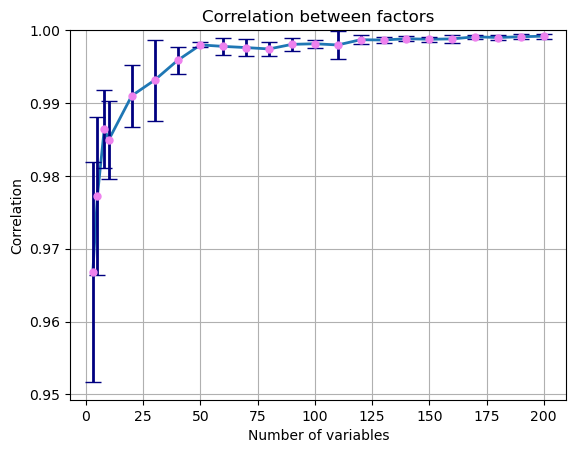

In [14]:
x = []
y = []
err = []

for key in results:
    el = results[key]
    x.append(key)
    y_t = []
    for el2 in el:
        [[factor1, factor2], [average1, average2]] = el2
        val = stt.spearmanr(factor1,factor2)[0]
        #val = stt.spearmanr(average1,average2)[0]
        y_t.append(val)
    y.append(np.mean(y_t))
    err.append(np.std(y_t))
    

#plt.errorbar(x,y,err)
plt.plot(x, y,linewidth=2)
plt.errorbar(x,y,err, fmt='o', ecolor='navy',color='violet',
             linewidth=2,capsize=6, markersize=5)
#plt.plot(x,y,'*')
plt.ylim(top=1)
plt.grid()
plt.title("Correlation between factors")
plt.ylabel("Correlation")
plt.xlabel("Number of variables")

Text(0.5, 0, 'Number of variables')

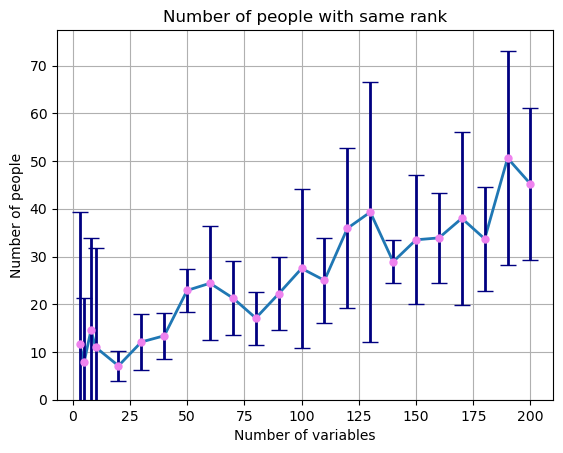

In [15]:
# Check how many are in the same position
x = []
y = []
err = []

for key in results:
    el = results[key]
    x.append(key)
    y_t = []
    for el2 in el:
        [[factor1, factor2], [average1, average2]] = el2
        rank1 = stt.rankdata(factor1)
        rank2 = stt.rankdata(factor2)
        
        val = np.sum(rank1==rank2)

        y_t.append(val)
    y.append(np.mean(y_t))
    err.append(np.std(y_t))
    
#plt.errorbar(x,y,err)
#plt.plot(x,y,'*')
plt.plot(x, y,linewidth=2)
plt.errorbar(x,y,err, fmt='o', ecolor='navy',color='violet',
             linewidth=2,capsize=6, markersize=5)
plt.grid()
plt.ylim(bottom=0)
plt.title("Number of people with same rank")
plt.ylabel("Number of people")
plt.xlabel("Number of variables")

Text(0.5, 0, 'Number of variables')

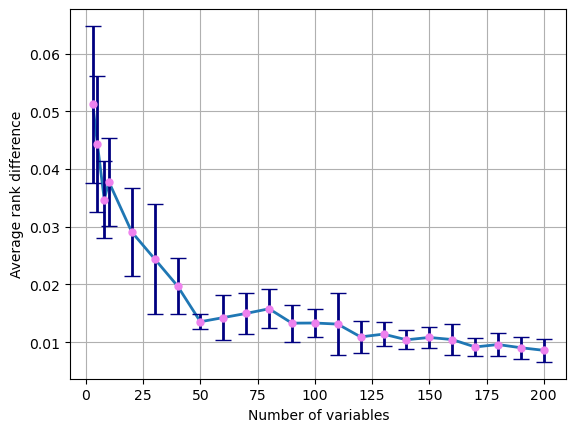

In [16]:
# Check the rank difference
x = []
y = []
err = []

for key in results:
    el = results[key]
    x.append(key)
    y_t = []
    for el2 in el:
        [[factor1, factor2], [average1, average2]] = el2
        rank1 = stt.rankdata(factor1)
        rank2 = stt.rankdata(factor2)
        
        val = np.mean(np.abs(rank1-rank2))/len(factor1)

        y_t.append(val)
    y.append(np.mean(y_t))
    err.append(np.std(y_t))
    
#plt.errorbar(x,y,err)
#plt.plot(x,y,'*')
plt.plot(x, y,linewidth=2)
plt.errorbar(x,y,err, fmt='o', ecolor='navy',color='violet',
             linewidth=2,capsize=6, markersize=5)

plt.grid()
#plt.title("Average rank difference")
plt.ylabel("Average rank difference")
plt.xlabel("Number of variables")

How many of the same are in the top 5%?

Text(0.5, 0, 'Number of variables')

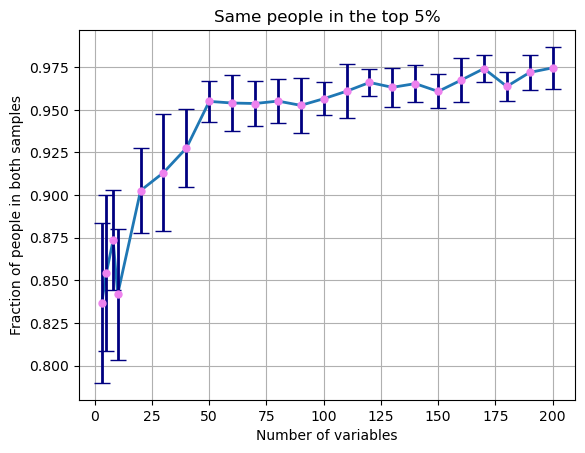

In [17]:
perc = 0.05

x = []
y = []
err = []

for key in results:
    el = results[key]
    x.append(key)
    y_t = []
    for el2 in el:
        [[factor1, factor2], [average1, average2]] = el2
        m1 = factor1/np.max(factor1)>1-perc
        m2 = factor2/np.max(factor2)>1-perc
        val = 2*np.sum(np.logical_and(m1,m2))/(np.sum(m1)+np.sum(m2))
        
        y_t.append(val)
    y.append(np.mean(y_t))
    err.append(np.std(y_t))
    
#plt.errorbar(x,y,err)
#plt.plot(x,y,'*')
plt.plot(x, y,linewidth=2)
plt.errorbar(x,y,err, fmt='o', ecolor='navy',color='violet',
             linewidth=2,capsize=6, markersize=5)

plt.grid()
plt.title("Same people in the top 5%")
plt.ylabel("Fraction of people in both samples")
plt.xlabel("Number of variables")

### Re-do for average (instead of factor analysis)

Text(0.5, 0, 'Number of variables')

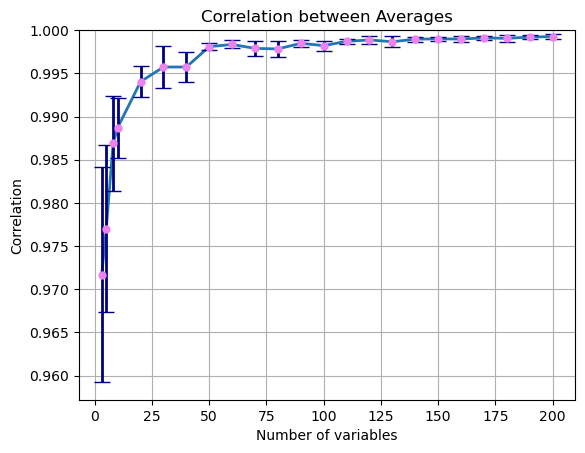

In [18]:
x = []
y = []
err = []

for key in results:
    el = results[key]
    x.append(key)
    y_t = []
    for el2 in el:
        [[factor1, factor2], [average1, average2]] = el2
        val = stt.spearmanr(average1,average2)[0]
        #val = stt.spearmanr(average1,average2)[0]
        y_t.append(val)
    y.append(np.mean(y_t))
    err.append(np.std(y_t))
    

#plt.errorbar(x,y,err)
#plt.plot(x,y,'*')
plt.plot(x, y,linewidth=2)
plt.errorbar(x,y,err, fmt='o', ecolor='navy',color='violet',
             linewidth=2,capsize=6, markersize=5)

plt.ylim(top=1)
plt.grid()
plt.title("Correlation between Averages")
plt.ylabel("Correlation")
plt.xlabel("Number of variables")

Text(0.5, 0, 'Number of variables')

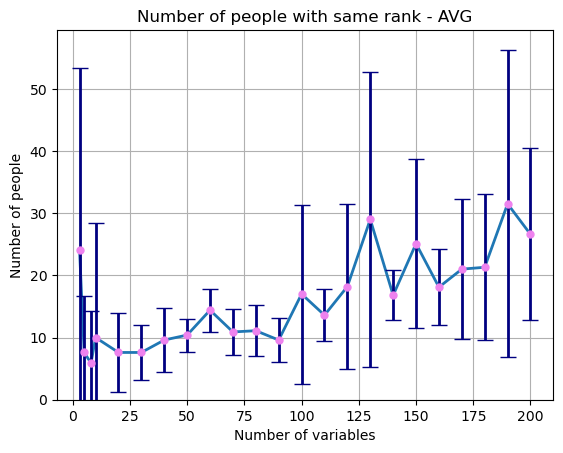

In [19]:
# Check how many are in the same position
x = []
y = []
err = []

for key in results:
    el = results[key]
    x.append(key)
    y_t = []
    for el2 in el:
        [[factor1, factor2], [average1, average2]] = el2
        rank1 = stt.rankdata(average1)
        rank2 = stt.rankdata(average2)
        
        val = np.sum(rank1==rank2)

        y_t.append(val)
    y.append(np.mean(y_t))
    err.append(np.std(y_t))
    
#plt.errorbar(x,y,err)
#plt.plot(x,y,'*')
plt.plot(x, y,linewidth=2)
plt.errorbar(x,y,err, fmt='o', ecolor='navy',color='violet',
             linewidth=2,capsize=6, markersize=5)

plt.grid()
plt.ylim(bottom=0)
plt.title("Number of people with same rank - AVG")
plt.ylabel("Number of people")
plt.xlabel("Number of variables")

Text(0.5, 0, 'Number of variables')

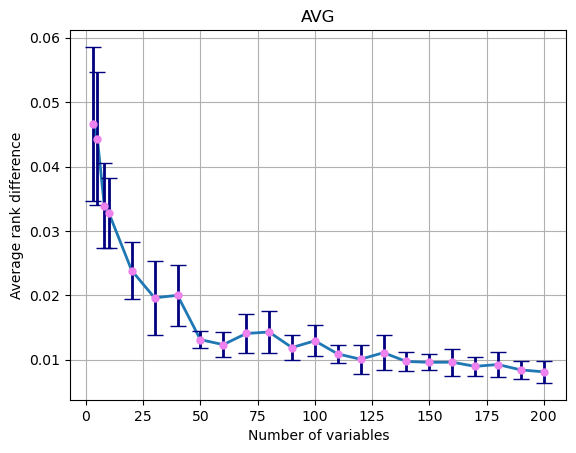

In [20]:
# Check the rank difference
x = []
y = []
err = []

for key in results:
    el = results[key]
    x.append(key)
    y_t = []
    for el2 in el:
        [[factor1, factor2], [average1, average2]] = el2
        rank1 = stt.rankdata(average1)
        rank2 = stt.rankdata(average2)
        
        val = np.mean(np.abs(rank1-rank2))/len(factor1)

        y_t.append(val)
    y.append(np.mean(y_t))
    err.append(np.std(y_t))
    
#plt.errorbar(x,y,err)
#plt.plot(x,y,'*')
plt.plot(x, y,linewidth=2)
plt.errorbar(x,y,err, fmt='o', ecolor='navy',color='violet',
             linewidth=2,capsize=6, markersize=5)

plt.grid()
plt.title("AVG")
plt.ylabel("Average rank difference")
plt.xlabel("Number of variables")

Text(0.5, 0, 'Number of variables')

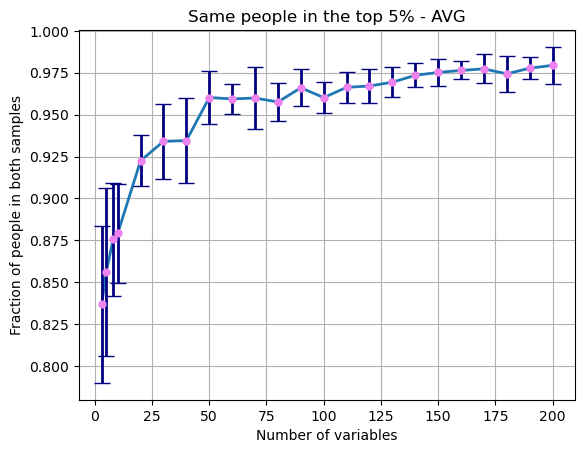

In [21]:
perc = 0.05

x = []
y = []
err = []

for key in results:
    el = results[key]
    x.append(key)
    y_t = []
    for el2 in el:
        [[factor1, factor2], [average1, average2]] = el2
        m1 = average1/np.max(average1)>1-perc
        m2 = average2/np.max(average2)>1-perc
        val = 2*np.sum(np.logical_and(m1,m2))/(np.sum(m1)+np.sum(m2))
        
        y_t.append(val)
    y.append(np.mean(y_t))
    err.append(np.std(y_t))
    
#plt.errorbar(x,y,err)
#plt.plot(x,y,'*')
plt.plot(x, y,linewidth=2)
plt.errorbar(x,y,err, fmt='o', ecolor='navy',color='violet',
             linewidth=2,capsize=6, markersize=5)

plt.grid()
plt.title("Same people in the top 5% - AVG")
plt.ylabel("Fraction of people in both samples")
plt.xlabel("Number of variables")

# Repeat for different weights

(i.e. one experimenter is much more likely to select some items, and the other is more likely to select other items)

In [22]:
if SAVE_OR_LOAD == "Load":
    with open("results_diff_weights.txt", "rb") as fp:   # Unpickling
        results_diff_weights = pickle.load(fp)
        results = results_diff_weights.copy()
        
elif SAVE_OR_LOAD == "Save":


    SAME_WEIGHTS = False

    results = {}

    contrast = 1

    pure_index = range(0, N_possible_quest)
    index = np.array(range(0, N_possible_quest))/(N_possible_quest-1)
    index_reversed = 1-index
    constant = index*0+1

    weight1 = contrast*index+(1-contrast)*constant
    weight2 = contrast*index_reversed+(1-contrast)*constant

    for items_to_select in items_to_select_vec:
        print(items_to_select)
        results[items_to_select] = []
        for rep in range(0,N_rep):
            print(rep)

            try:
                # Random choice
                choice1 = random.choices(pure_index, k=items_to_select, weights=weight1)
                choice1 = list(set(choice1))

                if SAME_WEIGHTS:
                    choice2 = random.choices(pure_index, k=items_to_select, weights=weight1)
                    choice2 = list(set(choice2))
                else:
                    choice2 = random.choices(pure_index, k=items_to_select, weights=weight2)
                    choice2 = list(set(choice2))

                items_selected1 = [possible_answers[i] for i in choice1]
                items_selected2 = [possible_answers[i] for i in choice2]


                #items_selected1 = random.choices(possible_answers, k=items_to_select, weights=weight1)
                #items_selected2 = random.choices(possible_answers, k=items_to_select, weights=weight2)

                factor1, average1 = get_factors_and_average(items_selected1)
                factor2, average2 = get_factors_and_average(items_selected2)

                results[items_to_select].append([[factor1, factor2], [average1, average2]])
            except:
                print("Error")
        print()

    results_diff_weights = results.copy()
    
    with open("results_diff_weights.txt", "wb") as fp:   #Pickling
        pickle.dump(results_diff_weights, fp)

Text(0.5, 0, 'Number of variables')

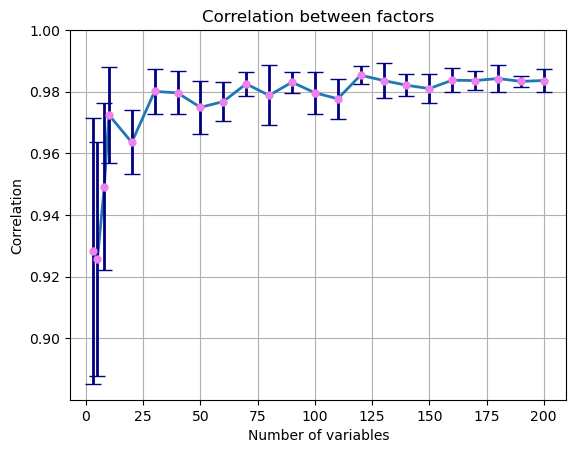

In [23]:
x = []
y = []
err = []

for key in results:
    el = results[key]
    x.append(key)
    y_t = []
    for el2 in el:
        [[factor1, factor2], [average1, average2]] = el2
        val = stt.spearmanr(factor1,factor2)[0]
        #val = stt.spearmanr(average1,average2)[0]
        y_t.append(val)
    y.append(np.mean(y_t))
    err.append(np.std(y_t))
    

#plt.errorbar(x,y,err)
#plt.plot(x,y,'*')
plt.plot(x, y,linewidth=2)
plt.errorbar(x,y,err, fmt='o', ecolor='navy',color='violet',
             linewidth=2,capsize=6, markersize=5)

plt.ylim(top=1)
plt.grid()
plt.title("Correlation between factors")
plt.ylabel("Correlation")
plt.xlabel("Number of variables")

Text(0.5, 0, 'Number of variables')

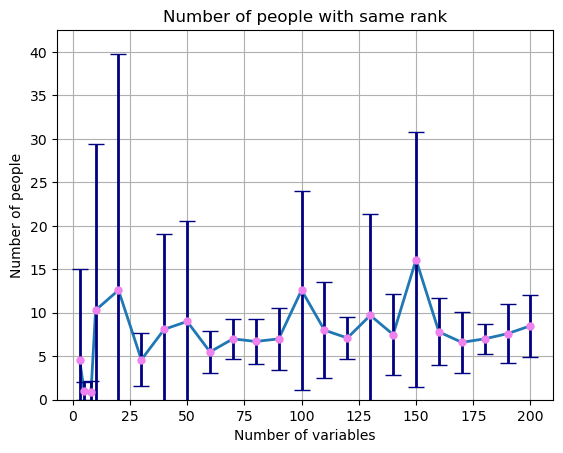

In [24]:
# Check how many are in the same position
x = []
y = []
err = []

for key in results:
    el = results[key]
    x.append(key)
    y_t = []
    for el2 in el:
        [[factor1, factor2], [average1, average2]] = el2
        rank1 = stt.rankdata(factor1)
        rank2 = stt.rankdata(factor2)
        
        val = np.sum(rank1==rank2)

        y_t.append(val)
    y.append(np.mean(y_t))
    err.append(np.std(y_t))
    
#plt.errorbar(x,y,err)
#plt.plot(x,y,'*')
plt.plot(x, y,linewidth=2)
plt.errorbar(x,y,err, fmt='o', ecolor='navy',color='violet',
             linewidth=2,capsize=6, markersize=5)

plt.grid()
plt.ylim(bottom=0)
plt.title("Number of people with same rank")
plt.ylabel("Number of people")
plt.xlabel("Number of variables")

Text(0.5, 0, 'Number of variables')

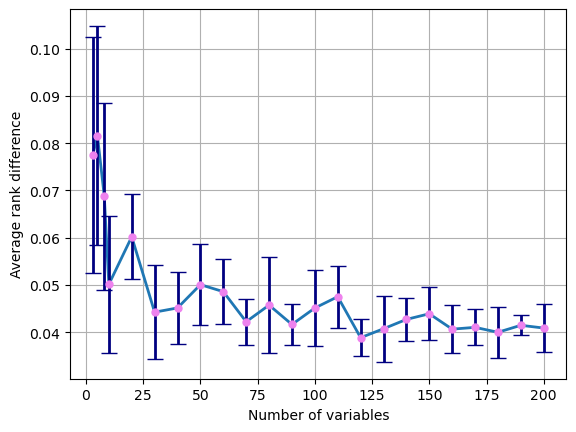

In [25]:
# Check the rank difference
x = []
y = []
err = []

for key in results:
    el = results[key]
    x.append(key)
    y_t = []
    for el2 in el:
        [[factor1, factor2], [average1, average2]] = el2
        rank1 = stt.rankdata(factor1)
        rank2 = stt.rankdata(factor2)
        
        val = np.mean(np.abs(rank1-rank2))/len(factor1)

        y_t.append(val)
    y.append(np.mean(y_t))
    err.append(np.std(y_t))
    
#plt.errorbar(x,y,err)
#plt.plot(x,y,'*')
plt.plot(x, y,linewidth=2)
plt.errorbar(x,y,err, fmt='o', ecolor='navy',color='violet',
             linewidth=2,capsize=6, markersize=5)

plt.grid()
#plt.title("Average rank difference")
plt.ylabel("Average rank difference")
plt.xlabel("Number of variables")

Text(0.5, 0, 'Number of variables')

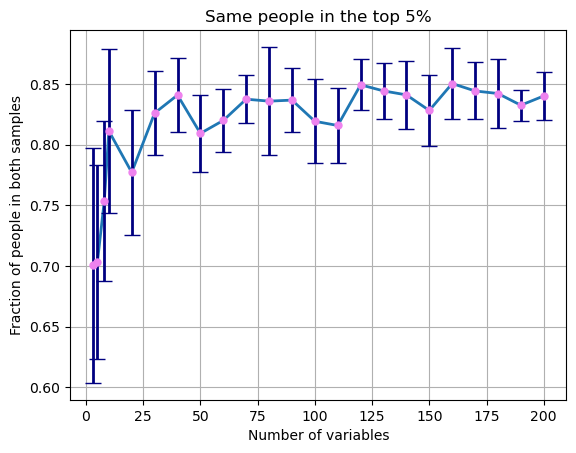

In [26]:
perc = 0.05

x = []
y = []
err = []

for key in results:
    el = results[key]
    x.append(key)
    y_t = []
    for el2 in el:
        [[factor1, factor2], [average1, average2]] = el2
        m1 = factor1/np.max(factor1)>1-perc
        m2 = factor2/np.max(factor2)>1-perc
        val = 2*np.sum(np.logical_and(m1,m2))/(np.sum(m1)+np.sum(m2))
        
        y_t.append(val)
    y.append(np.mean(y_t))
    err.append(np.std(y_t))
    
plt.plot(x, y,linewidth=2)
plt.errorbar(x,y,err, fmt='o', ecolor='navy',color='violet',
             linewidth=2,capsize=6, markersize=5)

plt.grid()
plt.title("Same people in the top 5%")
plt.ylabel("Fraction of people in both samples")
plt.xlabel("Number of variables")

### Repeat for the average

Text(0.5, 0, 'Number of variables')

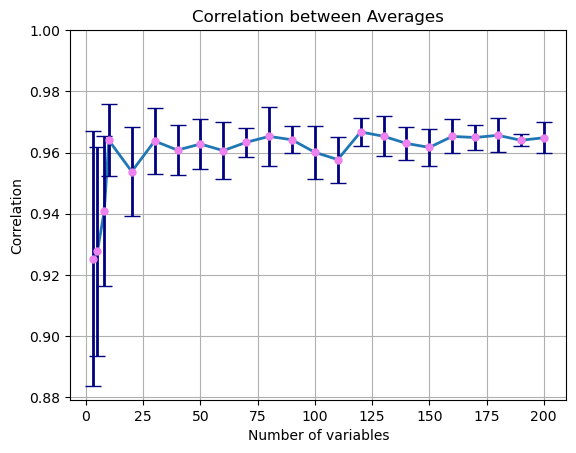

In [27]:
x = []
y = []
err = []

for key in results:
    el = results[key]
    x.append(key)
    y_t = []
    for el2 in el:
        [[factor1, factor2], [average1, average2]] = el2
        val = stt.spearmanr(average1,average2)[0]
        #val = stt.spearmanr(average1,average2)[0]
        y_t.append(val)
    y.append(np.mean(y_t))
    err.append(np.std(y_t))
    

plt.plot(x, y,linewidth=2)
plt.errorbar(x,y,err, fmt='o', ecolor='navy',color='violet',
             linewidth=2,capsize=6, markersize=5)

plt.ylim(top=1)
plt.grid()
plt.title("Correlation between Averages")
plt.ylabel("Correlation")
plt.xlabel("Number of variables")

Text(0.5, 0, 'Number of variables')

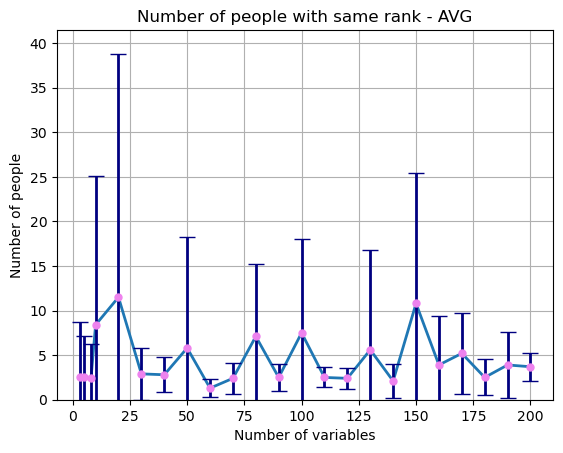

In [28]:
# Check how many are in the same position
x = []
y = []
err = []

for key in results:
    el = results[key]
    x.append(key)
    y_t = []
    for el2 in el:
        [[factor1, factor2], [average1, average2]] = el2
        rank1 = stt.rankdata(average1)
        rank2 = stt.rankdata(average2)
        
        val = np.sum(rank1==rank2)

        y_t.append(val)
    y.append(np.mean(y_t))
    err.append(np.std(y_t))
    
#plt.errorbar(x,y,err)
#plt.plot(x,y,'*')
plt.plot(x, y,linewidth=2)
plt.errorbar(x,y,err, fmt='o', ecolor='navy',color='violet',
             linewidth=2,capsize=6, markersize=5)

plt.grid()
plt.ylim(bottom=0)
plt.title("Number of people with same rank - AVG")
plt.ylabel("Number of people")
plt.xlabel("Number of variables")

Text(0.5, 0, 'Number of variables')

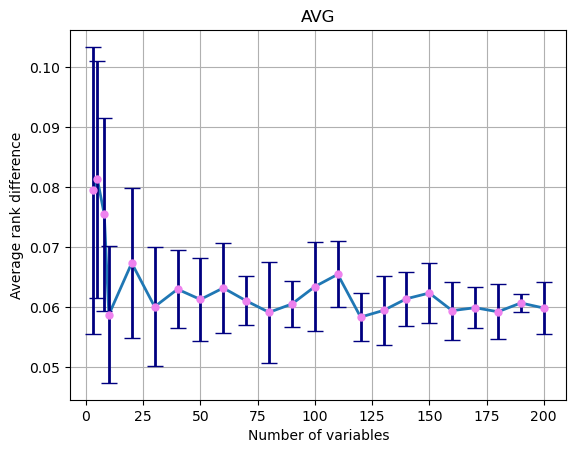

In [29]:
# Check the rank difference
x = []
y = []
err = []

for key in results:
    el = results[key]
    x.append(key)
    y_t = []
    for el2 in el:
        [[factor1, factor2], [average1, average2]] = el2
        rank1 = stt.rankdata(average1)
        rank2 = stt.rankdata(average2)
        
        val = np.mean(np.abs(rank1-rank2))/len(factor1)

        y_t.append(val)
    y.append(np.mean(y_t))
    err.append(np.std(y_t))
    
#plt.errorbar(x,y,err)
#plt.plot(x,y,'*')
plt.plot(x, y,linewidth=2)
plt.errorbar(x,y,err, fmt='o', ecolor='navy',color='violet',
             linewidth=2,capsize=6, markersize=5)

plt.grid()
plt.title("AVG")
plt.ylabel("Average rank difference")
plt.xlabel("Number of variables")

Text(0.5, 0, 'Number of variables')

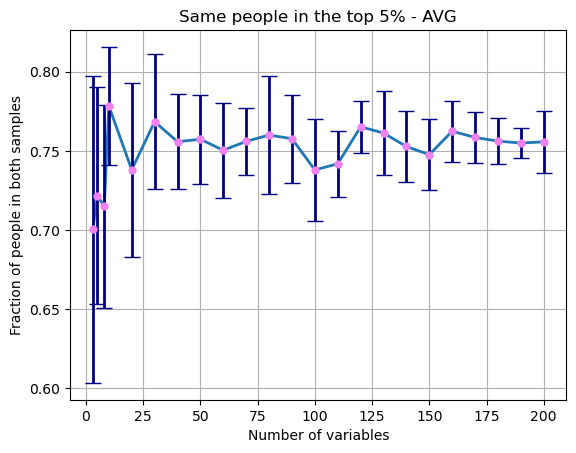

In [30]:
perc = 0.05

x = []
y = []
err = []

for key in results:
    el = results[key]
    x.append(key)
    y_t = []
    for el2 in el:
        [[factor1, factor2], [average1, average2]] = el2
        m1 = average1/np.max(average1)>1-perc
        m2 = average2/np.max(average2)>1-perc
        val = 2*np.sum(np.logical_and(m1,m2))/(np.sum(m1)+np.sum(m2))
        
        y_t.append(val)
    y.append(np.mean(y_t))
    err.append(np.std(y_t))
    
#plt.errorbar(x,y,err)
#plt.plot(x,y,'*')
plt.plot(x, y,linewidth=2)
plt.errorbar(x,y,err, fmt='o', ecolor='navy',color='violet',
             linewidth=2,capsize=6, markersize=5)

plt.grid()
plt.title("Same people in the top 5% - AVG")
plt.ylabel("Fraction of people in both samples")
plt.xlabel("Number of variables")